In [1]:
from z3 import *
import numpy as np
import random
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../../../"))

# our library
from src.mcmc_sat import smt, mcmc, utils

## Model definition (in Z3)

We start by defining a model as an SMT problem using Z3

In [2]:
# We create five Integer variables
num_vars = 5*2
x = [Int(f'x{i}') for i in range(num_vars)] # (age, sex)

In [3]:
# We define the model using the variables above

s = Solver() # get an instance of a Z3 solver

# model constraints
s.add(0<=x[0])
s.add(x[0]<=x[1])
s.add(x[1]<=x[2])
s.add(x[2]==30) #  median
s.add(x[2]<=x[3])
s.add(x[3]<=x[4])
s.add(x[4]<=125)

s.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5) #average

for i in range(5,10):
    s.add(0<=x[i])
    s.add(x[i]<=1)

s.add(x[5] + x[6] + x[7] + x[8] + x[9] == 3) # only 3 males

s.add(x[0]*x[5] + x[1]*x[6] + x[2]*x[7] + x[3]*x[8] + x[4]*x[9] == 44*3) # average age of males


In [6]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='megasampler',
                                           z3_problem=s,
                                           timeout_sampler=60*10)

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 20
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 10
Reals 0
Formula tree depth 6
--------------------------------------------
starting MeGASampler
Formula is satisfiable
MAX-SMT returned 'unknown' (timeout?)
Stopping: timeout
---------SOLVING STATISTICS--------
do_epoch time: 391.71
epoch time: 599.929
grow_seed time: 23.0666
initial_solving time: 0.0105214
output time: 1.06222
start_epoch time: 208.265
total time: 600.111
Epochs: 57209
MAX-SMT calls: 57210
SMT calls: 1
Assignments considered (with repetitions): 5835217
Models (with repetitions): 5835216
Unique models (# samples in file): 434
-----------------------------------
The parameter `solver_samples` only contains 434 samples. Thus, every chain will contain 434 instead of 434. Try running the SAT/SMT sampler longer to obtain more samples.



In [4]:
MEGASAMPLER_INPUT_DIR = 'megasampler_input'
megasampler_input_file = 'z3_problem.smt2'
megasampler_input_filepath = f'{MEGASAMPLER_INPUT_DIR}/{megasampler_input_file}'

smt.save_smt2(solver=s, filepath=megasampler_input_filepath)

In [5]:
# We execute megasampler \o/
MEGASAMPLER_OUTPUT_DIR = 'megasampler_output'
smt.execute_megasampler(input_filepath=megasampler_input_filepath,
                        output_dir=MEGASAMPLER_OUTPUT_DIR)

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 20
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 10
Reals 0
Formula tree depth 6
--------------------------------------------
starting MeGASampler


Formula is satisfiable
MAX-SMT returned 'unknown' (timeout?)
Stopping: timeout
---------SOLVING STATISTICS--------
do_epoch time: 1202.31
epoch time: 1799.82
grow_seed time: 57.0817
initial_solving time: 0.0240505
output time: 3.8743
start_epoch time: 597.317
total time: 1800.04
Epochs: 102395
MAX-SMT calls: 102396
SMT calls: 1
Assignments considered (with repetitions): 10444189
Models (with repetitions): 10444188
Unique models (# samples in file): 502
-----------------------------------


Megasampler stores the samples in a file. The file is stored in the directory passed as parameter in the above function. In what follows, we parse this file to produce a list of samples. Each sample is encoded as a dictionary where the key is the variable name and the value the sample.

In [6]:
# Define output files with samples
file_samples = f'{MEGASAMPLER_OUTPUT_DIR}/{megasampler_input_file}.samples'

In [7]:
# We parse the samples
samples = smt.parse_megasamples(file_samples)

In [8]:
# We run MCMC using the "megasamples"
trace = mcmc.sample_mh_trace(10000,4,samples)

The parameter `solver_samples` only contains 502 samples. Thus, every chain will contain 502 instead of 10000. Try running the SAT/SMT sampler longer to obtain more samples.


## Posterior

We show the posterior trace plots and summary statistics for each variable.

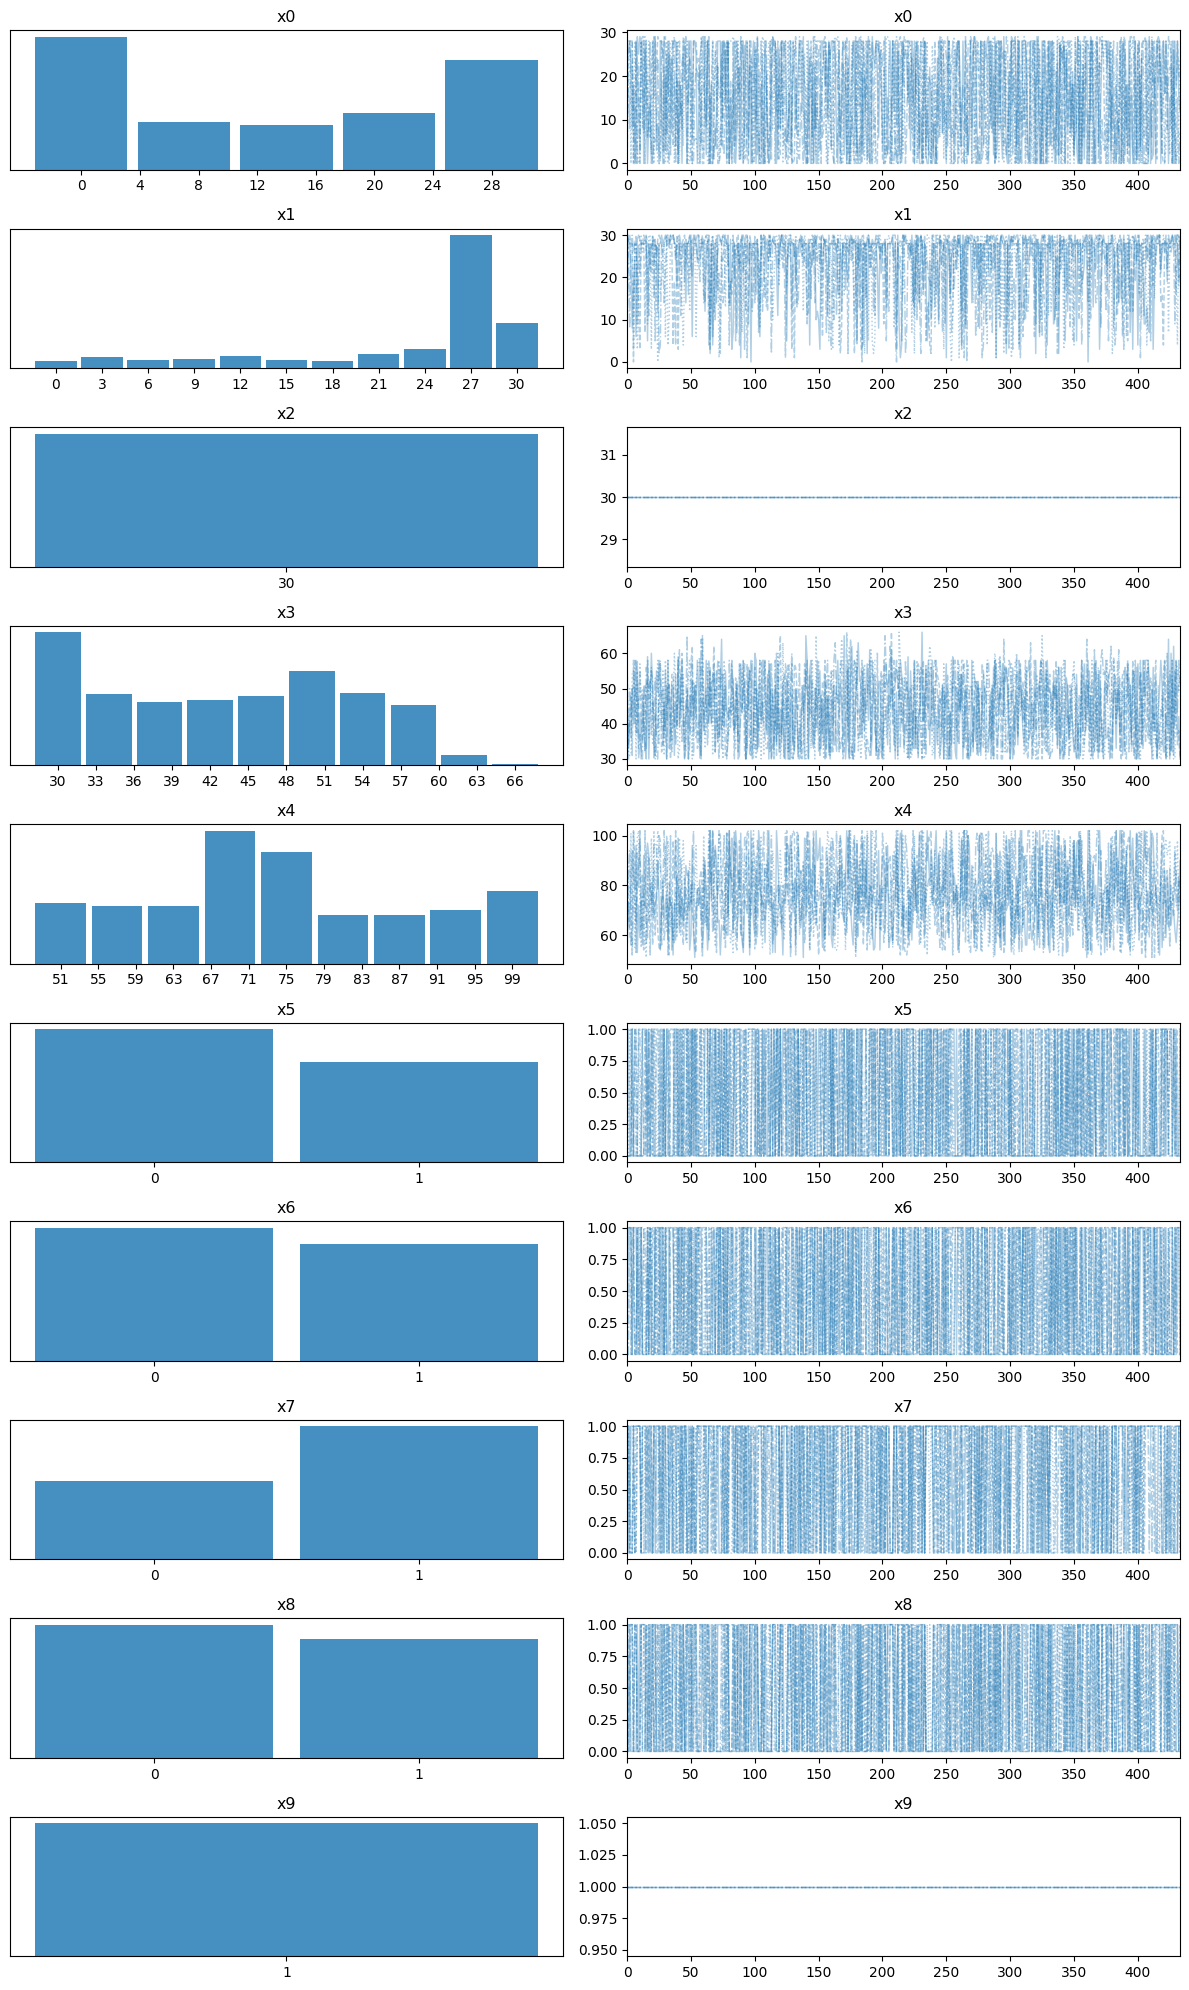

In [7]:
# Plot the posterior
az.plot_trace(trace);
plt.savefig('megasampler_trace_plot.png', dpi=150);

In [8]:
# Diagnostics
az.summary(trace)

/work/miniconda3/envs/sat_metropolis/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/work/miniconda3/envs/sat_metropolis/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/work/miniconda3/envs/sat_metropolis/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/work/miniconda3/envs/sat_metropolis/lib/python3.13/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,14.903,11.380,0.0,28.0,0.278,0.080,1699.0,1652.0,1.0
x1,23.703,8.218,5.0,30.0,0.198,0.166,1722.0,1736.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,NaN,1736.0,1736.0,NaN
x3,44.297,9.793,30.0,58.0,0.227,0.100,1852.0,1638.0,1.0
x4,77.097,14.391,55.0,102.0,0.353,0.178,1665.0,1736.0,1.0
x5,0.431,0.495,0.0,1.0,0.011,0.002,1874.0,1736.0,1.0
x6,0.468,0.499,0.0,1.0,0.012,0.001,1853.0,1736.0,1.0
x7,0.629,0.483,0.0,1.0,0.011,0.003,1826.0,1736.0,1.0
x8,0.472,0.499,0.0,1.0,0.012,0.001,1804.0,1736.0,1.0
x9,1.000,0.000,1.0,1.0,0.000,NaN,1736.0,1736.0,NaN


In [9]:
utils.save_trace(trace, f'db_cacm_SMT_{num_vars}.nc')